In [1]:
import h3ppy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from astropy.io import fits
from lmfit.models import LinearModel

import os

spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath("./../plots") + "/"
profile_dir = os.path.abspath("./profiles") + "/"

juph2 = read_csv('./profiles/JupH2Plot.csv', sep=',', header=None, skiprows=1)
juph3p = read_csv('./profiles/JupH3+Plot.csv', sep=',', header=None, skiprows=1)
# juptp = read_csv('./profiles/JupTP.csv', sep=',', header=None, skiprows=1)
juptao = read_csv('./profiles/JupTao.csv', sep=',', header=None, skiprows=1)

waverange36 = fits.open(spec_dir + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

wave_pix_scale_36 = 2.908e-5

waveh2 = fits.open("h2_wave_to_fit.fits", ignore_missing_end=True)[0].data
waveh3p = fits.open("h3p_wave_to_fit.fits", ignore_missing_end=True)[0].data

###############################

h3p_alt = juph3p[1].to_numpy()
h3p_local_dens = juph3p[0].to_numpy()

k_sort = np.argsort(h3p_alt)
h3p_alt = h3p_alt[k_sort]
h3p_local_dens = h3p_local_dens[k_sort]

h2_alt = juph2[1].to_numpy()
h2_local_dens = juph2[0].to_numpy()

h2_sort = np.argsort(h2_alt)
h2_alt = h2_alt[h2_sort]
h2_local_dens = h2_local_dens[h2_sort]

# jup_p = juptp[1].to_numpy()
# jup_t = juptp[0].to_numpy()

alt_Tao = juptao[1].to_numpy()
temp_Tao = juptao[0].to_numpy()

alt_Tao_sort = np.argsort(alt_Tao)
alt_Tao = alt_Tao[alt_Tao_sort]
temp_Tao = temp_Tao[alt_Tao_sort]

Text(0, 0.5, 'Altitude [km]')

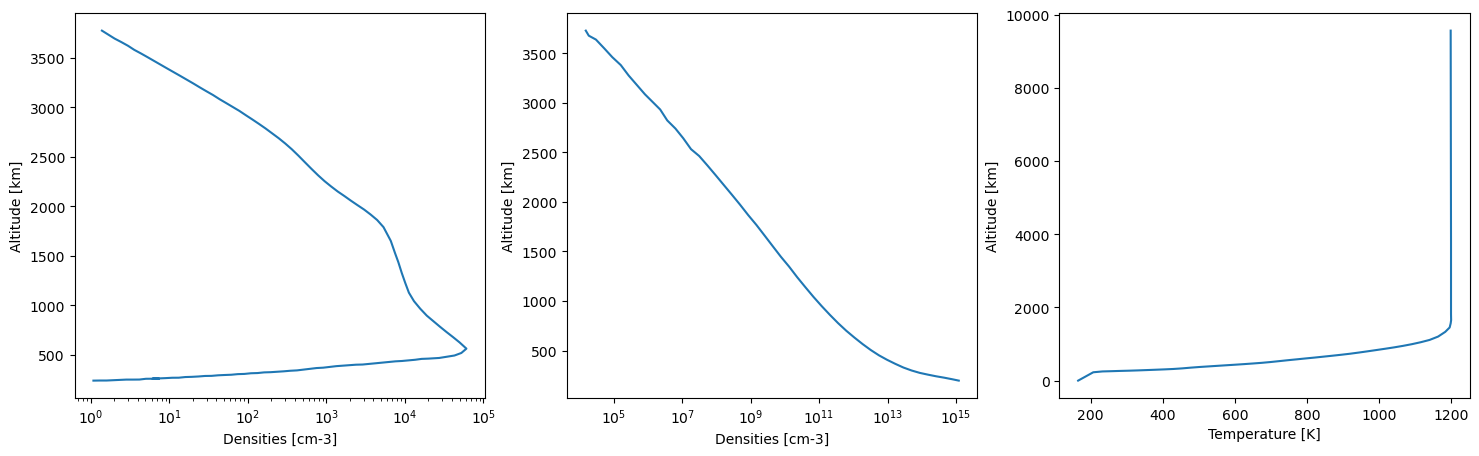

In [3]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(1,3,1)
ax1.plot(h3p_local_dens, h3p_alt)
ax1.set_xscale('log')
ax1.set_xlabel('Densities [cm-3]')
ax1.set_ylabel('Altitude [km]')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(h2_local_dens, h2_alt)
ax2.set_xscale('log')
ax2.set_xlabel('Densities [cm-3]')
ax2.set_ylabel('Altitude [km]')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(temp_Tao, alt_Tao)
ax3.set_xlabel('Temperature [K]')
ax3.set_ylabel('Altitude [km]')

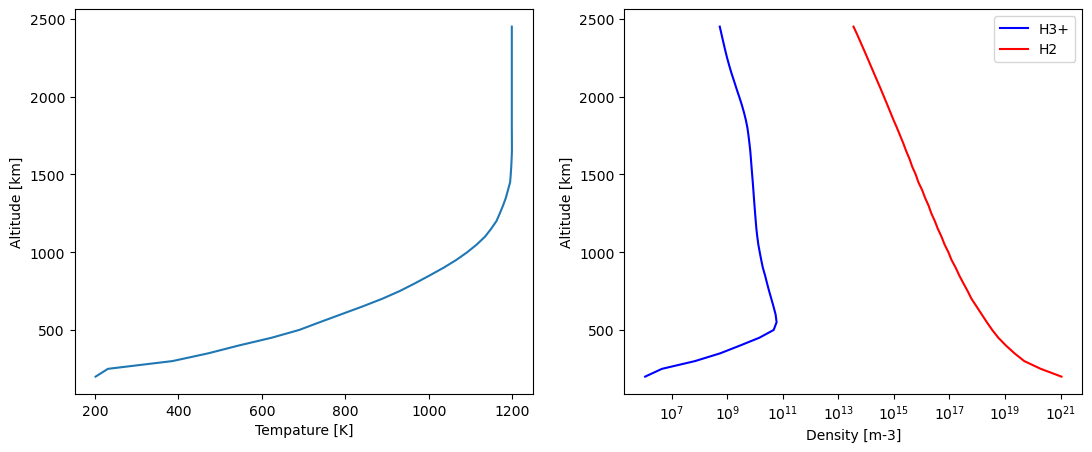

In [40]:
scale_alt = np.arange(200, 2500, 50) # km

# alt_scale2 = np.zeros(20)

scale_temp = np.interp(scale_alt, alt_Tao, temp_Tao)
# scale_temp = scale_temp * (3/6) + 400

# t_interp1 = np.interp(alt_scale, jup_tao_h, jup_tao_t)
# t_interp2 = np.zeros(len(t_interp1)) + 1200
# t_interp = (t_interp1 + t_interp2)/2

h3p_scale_local_dens = np.interp(scale_alt, h3p_alt, h3p_local_dens) * 1e6 # per cm3 to per m3
h2_scale_local_dens = np.interp(scale_alt, h2_alt, h2_local_dens) * 1e6

# h3p_scale_column_dens = h3p_scale_local_dens * 20e3 # 20km to m
# h2_scale_column_dens = h2_scale_local_dens * 20e3

# h3p_col_dens = np.sum(h3p_interp*1e6*20e3) # 20 km per layer defined in the alt_scale
# h2_col_dens = np.sum(h2_interp*1e6*20e3)

# t_interp[t_interp < 500] = 500

# H = 27 # Jupiter scale height [km]
# jup_h = -H * np.log(jup_p)

# h3p_interp_m3 = h3p_interp*1e6 # 

# h2_interp_m3 = h2_interp*1e6 # per cm3 to per m3
# h2_interp_m3[h2_interp_m3 > 1e20] = 1e20

fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(scale_temp, scale_alt)
ax1.set_xlabel('Tempature [K]')
ax1.set_ylabel('Altitude [km]')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(h3p_scale_local_dens, scale_alt, 'b-', label='H3+')
ax2.plot(h2_scale_local_dens, scale_alt, 'r-', label='H2')
ax2.set_xlabel('Density [m-3]')
ax2.set_ylabel('Altitude [km]')
ax2.set_xscale('log')
ax2.legend()

Text(0, 0.5, 'height [km]')

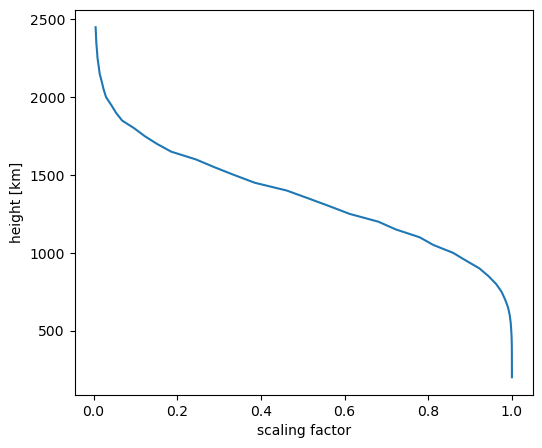

In [45]:
import csv

H2_Dens_LTE = []
H2_Temp_LTE = []
LTE_factor = []

with open (profile_dir+'HP3Cool_Jup_vals.txt', 'r') as f:
    
    first_column = [row[0] for row in csv.reader(f,delimiter='\t')]
    
for a in range(len(first_column)):
    row = first_column[a]
    H2_Dens_LTE.append(float(row[4:15]))
    H2_Temp_LTE.append(float(row[19:30]))
    LTE_factor.append(float(row[49:60]))

LTE_factor_matrix = np.transpose(np.reshape(LTE_factor, newshape=(181, 33)))

temp_list = np.array(np.arange(300, 1101, 25))
dens_list = np.array(10**(np.arange(10, 19.01, 0.05)))

def non_LTE_scaling(h2temp, h2dens):

    scalings = np.transpose(np.reshape(LTE_factor, newshape=(181, 33)))

    temp_list = np.array(np.arange(300, 1101, 25))
    dens_list = np.array(10**(np.arange(10, 19.01, 0.05)))
    
    # temp_list = [200, 300, 600, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
    # dens_list = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18, 1e20, 1e22]

    # scalings = np.array([
    #     [0.0000, 0.0014, 0.1182, 0.9306, 0.9993, 1.0000, 1.0002, 1.],
    #     [0.0000, 0.0001, 0.0067, 0.3931, 0.9848, 0.9998, 1.0000, 1.],
    #     [0.0000, 0.0000, 0.0011, 0.0313, 0.7449, 0.9965, 1.0000, 1.],
    #     [0.0000, 0.0000, 0.0013, 0.0108, 0.4955, 0.9866, 0.9999, 1.],
    #     [0.0000, 0.0000, 0.0013, 0.0064, 0.3640, 0.9701, 0.9997, 1.],
    #     [0.0000, 0.0000, 0.0011, 0.0049, 0.2894, 0.9499, 0.9995, 1.],
    #     [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992, 1.],
    #     [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992, 1.],
    #     [0.0000, 0.0000, 0.0008, 0.0036, 0.2064, 0.9014, 0.9988, 1.],
    #     [0.0000, 0.0000, 0.0007, 0.0034, 0.1961, 0.8923, 0.9987, 1.],
    #     [0.0000, 0.0000, 0.0007, 0.0033, 0.1889, 0.8854, 0.9985, 1.],
    #     [0.0000, 0.0000, 0.0007, 0.0033, 0.1836, 0.8802, 0.9985, 1.]
    # ])

    if h2temp >= temp_list[-1]:
        temp_index = len(temp_list)  # Set to the boundary index
    else:
        temp_index = np.digitize(h2temp, temp_list, right=True)

    if h2dens >= dens_list[-1]:
        dens_index = len(dens_list)  # Set to the boundary index
    else:
        dens_index = np.digitize(h2dens, dens_list, right=True)

    # Ensure the indices are within the valid range
    temp_index = max(0, min(temp_index, len(temp_list) - 1))
    dens_index = max(0, min(dens_index, len(dens_list) - 1))

    
    # Ensure index not rolling to the other end
    if temp_index <= 0:
        temp_index = 1

    if dens_index <= 0:
        dens_index = 1

    # calculate scaling
    if h2dens > dens_list[-1]:
        scaling = scalings[temp_index][dens_index]
    elif h2temp > temp_list[-1]:
        scaling = scalings[temp_index][dens_index - 1]
    elif h2dens < dens_list[0]:
        scaling = scalings[temp_index - 1][dens_index]
    elif h2temp < temp_list[0]:
        scaling = scalings[temp_index - 1][dens_index - 1]
    else:
        # interpolate two adjacent saclings for a given h2temp
        
        top = scalings[temp_index - 1, :]
        bot = scalings[temp_index, :]

    
        # interpolate top scaling
        
        x = np.log10(np.array(dens_list))
        y = np.copy(top)

        f = scipy.interpolate.interp1d(x, y)
        
        xs = np.arange(x[0], x[-1]+1)

        top_interp = f(np.log10(h2dens))
        
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()
        
        # interpolate bot scaling
        
        x = np.log10(np.array(dens_list))
        y = np.copy(bot)
        
        f = scipy.interpolate.interp1d(x, y)
    
        xs = np.arange(x[0], x[-1]+1)
        
        bot_interp = f(np.log10(h2dens))
    
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()
        
    
        # interpolate between top_interp and bot_interp
        
        x = [temp_list[temp_index - 1], temp_list[temp_index]]
        y = [top_interp, bot_interp]
    
        f = scipy.interpolate.interp1d(x, y)

        xs = np.arange(x[0], x[-1]+1, 10)

        scaling = f(h2temp)
    
        # fig, ax = plt.subplots(figsize=(6.5, 4))
        # ax.plot(x, y, 'k.')
        # ax.plot(xs, f(xs), 'b-', label='linear')
        # ax.legend()

    return scaling

# h2temp = 251
# h2dens = 5.343e11
# scaling_factor = non_LTE_scaling(h2temp, h2dens)
# print(scaling_factor)


non_LTE_scaling_list = []

for i, alt in enumerate(scale_alt):
    scaling = non_LTE_scaling(scale_temp[i], h2_scale_local_dens[i])
    # print(scaling)

    non_LTE_scaling_list.append(scaling)

non_LTE_scaling_factor = np.array(non_LTE_scaling_list)

fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(non_LTE_scaling_factor, scale_alt, '-')
ax1.set_xlabel('scaling factor')
ax1.set_ylabel('height [km]')

# ax2 = fig.add_subplot(1,2,2)
# im2 = ax2.tricontour(scale_temp, h2_scale_local_dens/1e6, np.array(non_LTE_scaling_factor))
# ax2.set_yscale('log')
# ax2.set_xlabel('temperature [K]')
# ax2.set_ylabel('density [/cm3]')
# ax2.invert_yaxis()
# cbar2 = plt.colorbar(im2)

In [99]:
waveh3p,waveh2

(array([2.1216776, 2.1217067, 2.1217358, 2.121765 , 2.121794 , 2.121823 ,
        2.1218522, 2.1218812, 2.1219103, 2.1219394, 2.1219685, 2.1219976,
        2.1220267, 2.1220558, 2.1220849, 2.122114 , 2.122143 , 2.122172 ,
        2.1222012, 2.1222303, 2.1222594, 2.1222885, 2.1223176, 2.1223466,
        2.1223757, 2.1224048, 2.122434 , 2.122463 , 2.1224918, 2.122521 ,
        2.1272836, 2.1273127, 2.1273417, 2.1273708, 2.1274   , 2.1274288,
        2.1274579, 2.127487 , 2.127516 , 2.127545 , 2.1275742, 2.1276033,
        2.1276324, 2.1276615, 2.1276906, 2.1277196, 2.1277487, 2.1277778,
        2.127807 , 2.127836 , 2.127865 , 2.1278942, 2.1308825, 2.1309116,
        2.1309407, 2.1309698, 2.1309988, 2.131028 , 2.131057 , 2.131086 ,
        2.1311152, 2.1311443, 2.1311734, 2.1312025, 2.1312315, 2.1312606,
        2.1312897, 2.1313188, 2.131348 , 2.1313767, 2.1314058, 2.131435 ,
        2.131464 , 2.131493 , 2.1315222, 2.1315513, 2.1315804, 2.1316094,
        2.1316385, 2.1316676, 2.131696

/opt/anaconda3/lib/python3.11/site-packages/h3ppy


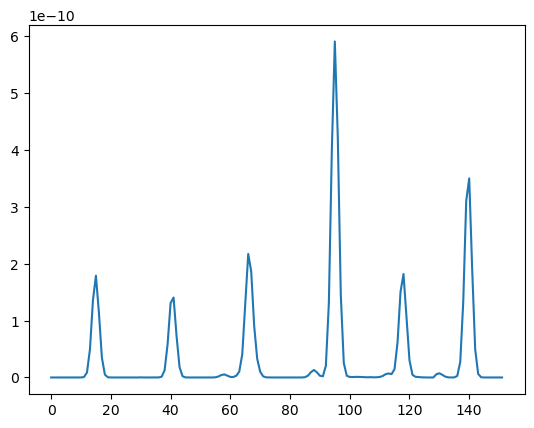

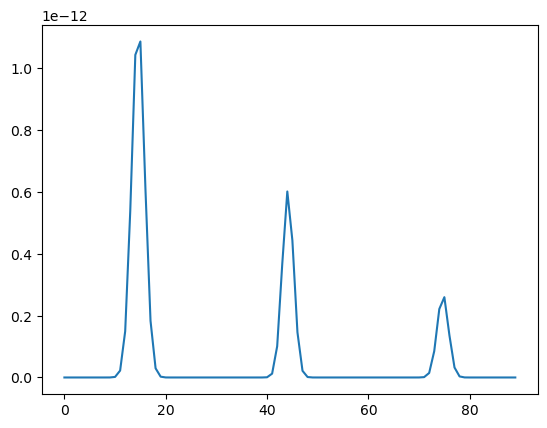

In [55]:
h3p = h3ppy.h3p(line_list_file="h3p_line_list_neale_1996_subset_211_215.txt")
h2 = h3ppy.h2()

h3p.set(wave = waveh3p, R = 25000)
h2.set(wave = waveh2, R = 25000)

h3p_radiance = []
h2_radiance = []

h3p_model_list = []
h2_model_list = []

h3p_tm_rate = []
h2_tm_rate = []

delta_waveh3p = waveh3p[1] - waveh3p[0]
delta_waveh2 = (waveh2[1] - waveh2[0])

for i, alt in enumerate(scale_alt):
    
    h3p.set(N = h3p_scale_local_dens[i], T = scale_temp[i])
    h2.set(N = h2_scale_local_dens[i], T = scale_temp[i])

    h3p_radiance.append(np.sum(h3p.model() * delta_waveh3p))
    h2_radiance.append(np.sum(h2.model() * delta_waveh2))

    h3p_tm_rate.append(np.sum(h3p.model()))
    h2_tm_rate.append(np.sum(h2.model()))

    h3p_model_list.append(h3p.model())
    h2_model_list.append(h2.model())


h3p_radiance = np.array(h3p_radiance)
h2_radiance = np.array(h2_radiance)

h3p_total_emission_rate = np.array(h3p_tm_rate)
h2_total_emission_rate = np.array(h2_tm_rate)

plt.figure()
plt.plot(h3p.model())

plt.figure()
plt.plot(h2.model())

(array([900]), array([800]))

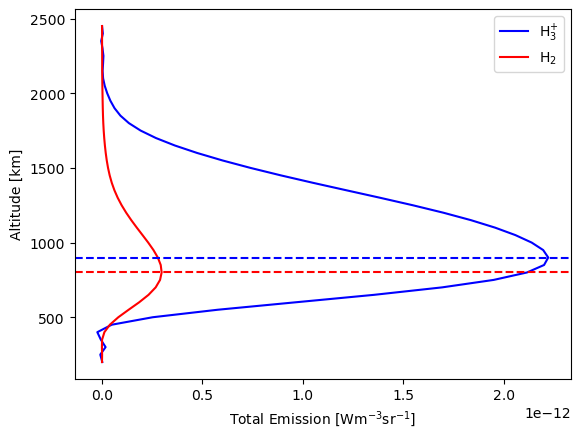

In [56]:
h3p_radiance_non_LTE = h3p_radiance * non_LTE_scaling_factor

h2_polyfit = np.polyfit(scale_alt, h2_radiance, 16)
h2_poly1d = np.poly1d(h2_polyfit)
h2_polynomial = h2_poly1d(scale_alt)

h3p_polyfit = np.polyfit(scale_alt, h3p_radiance_non_LTE, 16)
h3p_poly1d = np.poly1d(h3p_polyfit)
h3p_polynomial = h3p_poly1d(scale_alt)

plt.figure()
# plt.plot(h3p_radiance_non_LTE, scale_alt, 'b-', label='H$_3^{+}$')
# plt.plot(h2_radiance, scale_alt, 'r-', label='H$_2$')
plt.plot(h3p_polynomial, scale_alt, 'b-', label='H$_3^{+}$')
plt.plot(h2_polynomial, scale_alt, 'r-', label='H$_2$')


# plt.axhline(scale_alt[h3p_radiance_non_LTE == np.max(h3p_radiance_non_LTE)], color='b', ls='--')
# plt.axhline(scale_alt[h2_radiance == np.max(h2_radiance)], color='r', ls='--')

plt.axhline(scale_alt[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
plt.axhline(scale_alt[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')


plt.xlabel('Total Emission [Wm$^{-3}$sr$^{-1}$]')
# plt.xlabel('Total Emission [Wm$^{-3}$sr$^{-1}$]')
plt.ylabel('Altitude [km]')
# plt.xscale('log')
plt.legend()

scale_alt[h3p_polynomial == np.max(h3p_polynomial)], scale_alt[h2_polynomial == np.max(h2_polynomial)]

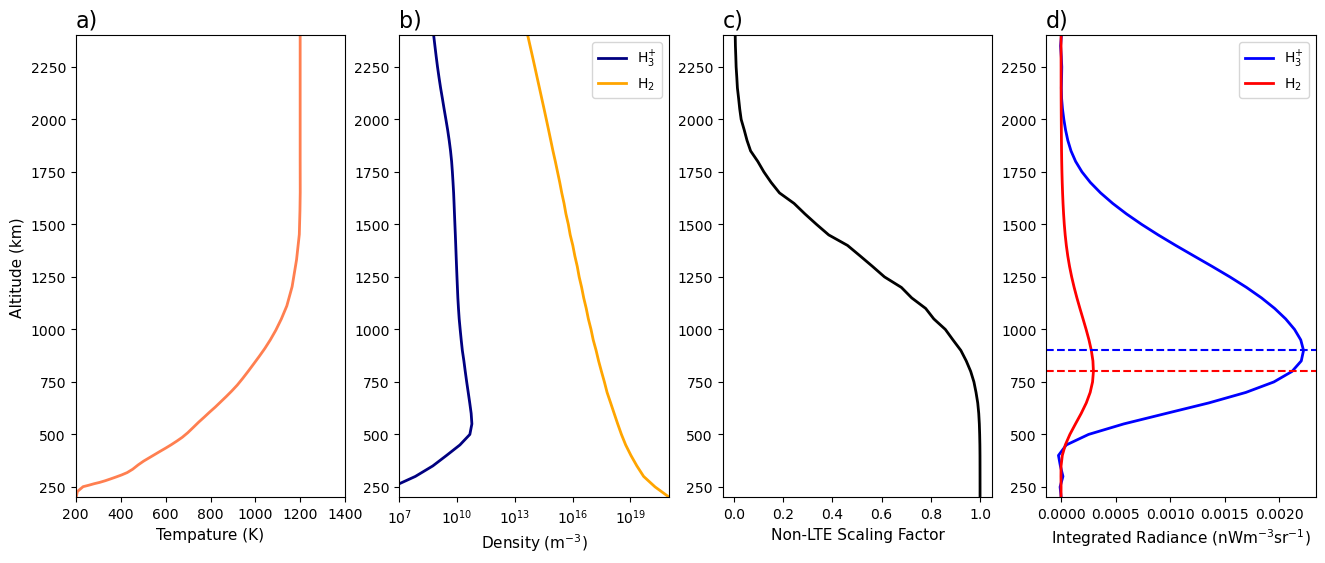

In [97]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1,4,1)
# ax1.plot(t_interp, alt_scale)
ax1.plot(temp_Tao, alt_Tao, c='coral', lw=2)
ax1.set_xlabel('Tempature (K)', fontsize=11)
ax1.set_ylabel('Altitude (km)', fontsize=11)
ax1.set_title('a)', loc='left', fontsize=16)
ax1.set_xlim(200,1400)
ax1.set_ylim(200,2400)

ax2 = fig.add_subplot(1,4,2)
ax2.plot(h3p_scale_local_dens, scale_alt, c='navy', ls='-', lw=2, label='H$_3^{+}$')
ax2.plot(h2_scale_local_dens, scale_alt, c='orange', ls='-', lw=2, label='H$_2$')
ax2.set_xlabel('Density (m$^{-3}$)', fontsize=11)
ax2.set_title('b)', loc='left', fontsize=16)
ax2.set_xscale('log')
ax2.legend()
ax2.set_xlim(1e7,1e21)
ax2.set_ylim(200,2400)

ax3 = fig.add_subplot(1,4,3)
ax3.plot(non_LTE_scaling_factor, scale_alt, 'k-', lw=2)
ax3.set_xlabel('Non-LTE Scaling Factor', fontsize=11)
ax3.set_title('c)', loc='left', fontsize=16)
ax3.set_ylim(200,2400)

ax4 = fig.add_subplot(1,4,4)
ax4.plot(h3p_polynomial*1e9, scale_alt, 'b-', lw=2, label='H$_3^{+}$')
ax4.plot(h2_polynomial*1e9, scale_alt, 'r-', lw=2, label='H$_2$')
ax4.axhline(scale_alt[h3p_polynomial == np.max(h3p_polynomial)], color='b', ls='--')
ax4.axhline(scale_alt[h2_polynomial == np.max(h2_polynomial)], color='r', ls='--')
ax4.set_xlabel('Integrated Radiance (nWm$^{-3}$sr$^{-1}$)', fontsize=11)
ax4.set_title('d)', loc='left', fontsize=16)
ax4.set_ylim(200,2400)
ax4.legend()

plt.savefig(plots_dir+"vertical_profile.pdf", dpi=300, bbox_inches="tight")

1.0
777.347295625214
1.094731759031567e+24


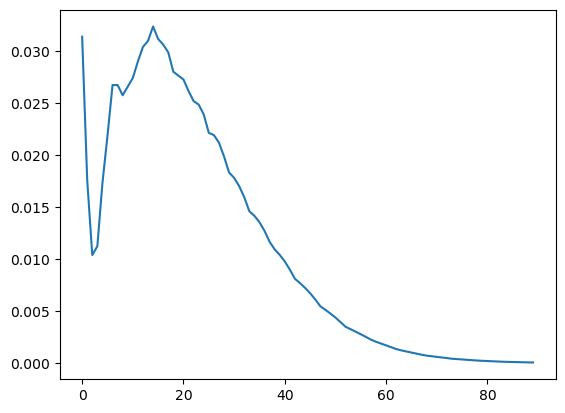

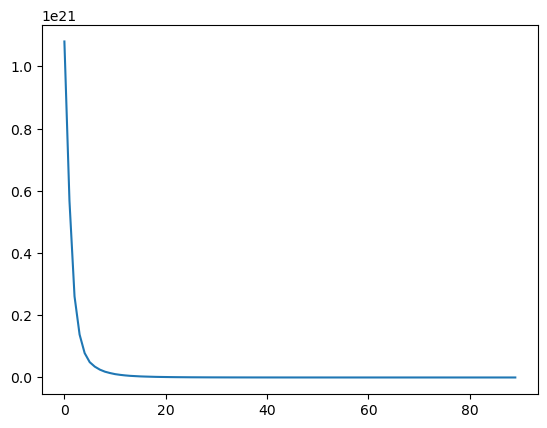

In [27]:
h2_prob = h2_radiance / np.sum(h2_radiance)
print(np.sum(h2_prob))


# plt.plot(t_interp)
plt.figure()
plt.plot(h2_prob)

plt.figure()
plt.plot(h2_scale_local_dens)

print(np.sum(scale_temp * h2_prob))
print(np.sum(h2_scale_local_dens * h2_prob) * 20000)

0.9999999999999999
908.1645940537895
4.81E+14


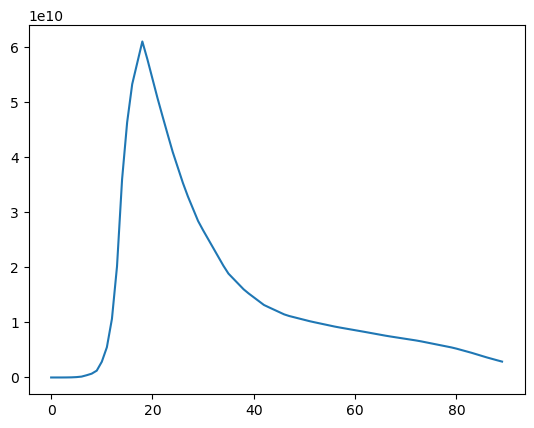

In [28]:
h3p_prob = h3p_radiance_non_LTE / np.sum(h3p_radiance_non_LTE)
print(np.sum(h3p_prob))


# plt.plot(t_interp)
# plt.plot(h3p_prob)

plt.figure()
plt.plot(h3p_scale_local_dens)

print(np.sum(scale_temp * h3p_prob))
print('{:0.2E}'.format(np.sum(h3p_scale_local_dens * h3p_prob * 20000)))

# print(round(np.sum(h3p_scale_local_dens * h3p_prob) * 20000, 1))

[h3ppy] Estimated density = 3.99E+16 m-2


/Users/RuoyanWang/anaconda3/lib/python3.11/site-packages/h3ppy


[h3ppy]  Spectrum parameters:
         Temperature    = 1036.6 +/- 68.4 [K]
         Column density = 3.29E+16 +/-  1.19E+16 [m-2]
         ------------------------------
         background_0 = -4.76E-05 +/- 4.74E-05
         offset_0 = -8.38E-08 +/- 1.17E-06
         sigma_0 = 3.55E-05 +/- 1.21E-06



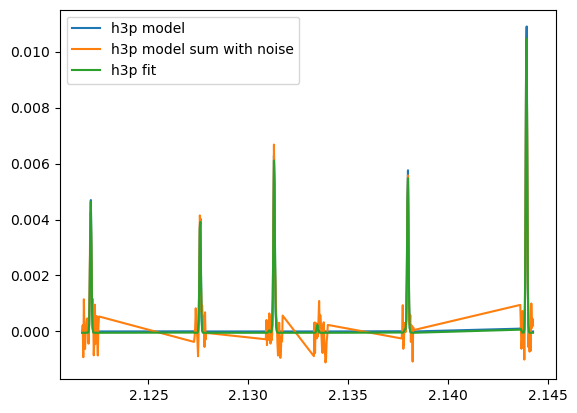

In [48]:
h3p = h3ppy.h3p()

h3p.set(wave = waveh3p, R = 25000)

h3p_model_array = np.array(h3p_model_list)
h3p_model_sum = np.sum(h3p_model_array, axis=0)*20e3

snr = 10
scale = np.max(h3p_model_sum) / snr / 2.0
noise = np.random.normal(size = len(h3p_model_sum), scale = scale).flatten()

h3p_model_sum_with_noise = h3p_model_sum + noise

h3p.set(wave = waveh3p, data=h3p_model_sum_with_noise, T=1000)

h3p.guess_density()

h3p_model = h3p.model()

h3p_fit = h3p.fit()

vars, errs = h3p.get_results()

plt.plot(waveh3p, h3p_model, label='h3p model')
plt.plot(waveh3p, h3p_model_sum_with_noise, label='h3p model sum with noise')
plt.plot(waveh3p, h3p_fit, label='h3p fit')
plt.legend()

[h3ppy] Estimated density = 5.14E+25 m-2
[h3ppy]  Spectrum parameters:
         Temperature    = 773.4 +/- 25.9 [K]
         Column density = 3.10E+25 +/-  1.18E+25 [m-2]
         ------------------------------
         background_0 = -1.72E-04 +/- 9.03E-05
         offset_0 = 3.16E-07 +/- 1.26E-06
         sigma_0 = 3.72E-05 +/- 1.31E-06



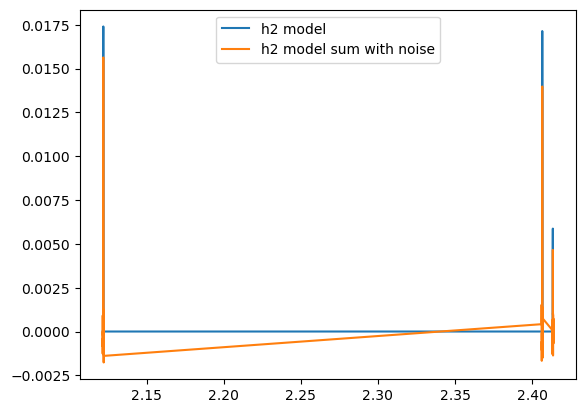

In [47]:
h2 = h3ppy.h2()

h2.set(wave = waveh2, R = 25000)

h2_model_array = np.array(h2_model_list)
h2_model_sum = np.sum(h2_model_array, axis=0)*20e3

snr = 10
scale = np.max(h2_model_sum) / snr / 2.0
noise = np.random.normal(size = len(h2_model_sum), scale = scale).flatten()

h2_model_sum_with_noise = h2_model_sum + noise

h2.set(wave = waveh2, data=h2_model_sum_with_noise, T=750)

h2.guess_density()

h2_model = h2.model()

h2_fit = h2.fit()

vars, errs = h2.get_results()

plt.plot(waveh2, h2_model, label='h2 model')
plt.plot(waveh2, h2_model_sum_with_noise, label='h2 model sum with noise')
# plt.plot(waveh2, h2_fit, label='h2 fit')
plt.legend()

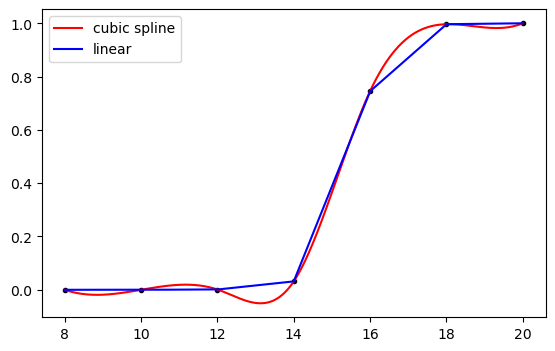

In [11]:
temp_list = [200, 300, 600, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
dens_list = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18, 1e20]

scalings = np.array([
    [0.0000, 0.0014, 0.1182, 0.9306, 0.9993, 1.0000, 1.0002],
    [0.0000, 0.0001, 0.0067, 0.3931, 0.9848, 0.9998, 1.0000],
    [0.0000, 0.0000, 0.0011, 0.0313, 0.7449, 0.9965, 1.0000],
    [0.0000, 0.0000, 0.0013, 0.0108, 0.4955, 0.9866, 0.9999],
    [0.0000, 0.0000, 0.0013, 0.0064, 0.3640, 0.9701, 0.9997],
    [0.0000, 0.0000, 0.0011, 0.0049, 0.2894, 0.9499, 0.9995],
    [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992],
    [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992],
    [0.0000, 0.0000, 0.0008, 0.0036, 0.2064, 0.9014, 0.9988],
    [0.0000, 0.0000, 0.0007, 0.0034, 0.1961, 0.8923, 0.9987],
    [0.0000, 0.0000, 0.0007, 0.0033, 0.1889, 0.8854, 0.9985],
    [0.0000, 0.0000, 0.0007, 0.0033, 0.1836, 0.8802, 0.9985]
])

x = np.log10(np.array(dens_list))
y = scalings[2,:]

cs = scipy.interpolate.CubicSpline(x, y)
f = scipy.interpolate.interp1d(x, y)

xs = np.arange(x[0], x[-1]+1)
xs = np.linspace(x[0], x[-1], 10000)

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'k.')
ax.plot(xs, cs(xs), 'r-', label='cubic spline')
ax.plot(xs, f(xs), 'b-', label='linear')
ax.legend()

# x = [temp_list[0], temp_list[1]]
# y = [scalings[0][0], scalings[1][0]]

# print(x,y)

# x_new = np.arange(temp_list[0], temp_list[1])

# y_new = np.interp(x_new, x, y)
# print(y_new)
# # 13.0

# plt.plot(x, y, "og-", x_new, y_new, "or");

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 2
    # variables        = 2
    chi-square         = 7.9934e-37
    reduced chi-square = 7.9934e-37
    Akaike info crit   = -163.620368
    Bayesian info crit = -166.234074
    R-squared          = 1.00000000
[[Variables]]
    slope:     -1.1200e-05 +/- 2.5288e-21 (0.00%) (init = -1.12e-05)
    intercept:  0.01006000 +/- 1.5278e-18 (0.00%) (init = 0.01006)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.9104


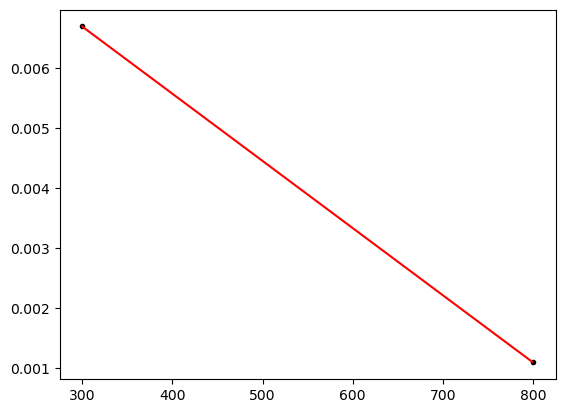

In [62]:
x = [temp_list[0], temp_list[1]]
y = [scalings[0][0], scalings[1][0]]

mod = LinearModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

k = out.params['slope'].value
m = out.params['intercept'].value

best_fit = k*(np.arange(temp_list[0], temp_list[1])) + m

plt.figure()
plt.plot(x, y,'k.', label = 'original')
plt.plot(np.arange(temp_list[0], temp_list[1]), best_fit, 'r', label = 'best fit')

In [68]:
import numpy as np
from lmfit.models import LinearModel

def non_LTE_scaling(h2temp, h2dens):
    temp_list = [200, 300, 600, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
    dens_list = [1e8, 1e10, 1e12, 1e14, 1e16, 1e18, 1e20]

    scalings = np.array([
        [0.0000, 0.0014, 0.1182, 0.9306, 0.9993, 1.0000, 1.0002],
        [0.0000, 0.0001, 0.0067, 0.3931, 0.9848, 0.9998, 1.0000],
        [0.0000, 0.0000, 0.0011, 0.0313, 0.7449, 0.9965, 1.0000],
        [0.0000, 0.0000, 0.0013, 0.0108, 0.4955, 0.9866, 0.9999],
        [0.0000, 0.0000, 0.0013, 0.0064, 0.3640, 0.9701, 0.9997],
        [0.0000, 0.0000, 0.0011, 0.0049, 0.2894, 0.9499, 0.9995],
        [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992],
        [0.0000, 0.0000, 0.0010, 0.0042, 0.2469, 0.9299, 0.9992],
        [0.0000, 0.0000, 0.0008, 0.0036, 0.2064, 0.9014, 0.9988],
        [0.0000, 0.0000, 0.0007, 0.0034, 0.1961, 0.8923, 0.9987],
        [0.0000, 0.0000, 0.0007, 0.0033, 0.1889, 0.8854, 0.9985],
        [0.0000, 0.0000, 0.0007, 0.0033, 0.1836, 0.8802, 0.9985]
    ])

    if h2temp >= temp_list[-1]:
        temp_index = len(temp_list)  # Set to the boundary index
    else:
        temp_index = np.digitize(h2temp, temp_list, right=True)

    if h2dens >= dens_list[-1]:
        dens_index = len(dens_list)  # Set to the boundary index
    else:
        dens_index = np.digitize(h2dens, dens_list, right=True)

    # Ensure the indices are within the valid range
    temp_index = max(0, min(temp_index, len(temp_list) - 1))
    dens_index = max(0, min(dens_index, len(dens_list) - 1))

    
    # Ensure index not rolling to the other end
    if temp_index <= 0:
        temp_index = 1

    if dens_index <= 0:
        dens_index = 1

    # calculate scaling
    if h2dens > dens_list[-1]:
        scaling = scalings[temp_index][dens_index]
    elif h2temp > temp_list[-1]:
        scaling = scalings[temp_index][dens_index - 1]
    elif h2dens < dens_list[0]:
        scaling = scalings[temp_index - 1][dens_index]
    elif h2temp < temp_list[0]:
        scaling = scalings[temp_index - 1][dens_index - 1]
    else:
        # four corners for interpolation
        top_left = scalings[temp_index - 1][dens_index - 1]
        top_right = scalings[temp_index - 1][dens_index]
        bot_left = scalings[temp_index][dens_index - 1]
        bot_right = scalings[temp_index][dens_index]
    
        # interpolate top_left and top_right
    
        x_top = [dens_list[dens_index - 1], dens_list[dens_index]]
        y_top = [top_left, top_right]
        
        mod = LinearModel()
    
        pars_top = mod.guess(y_top, x=np.log10(np.array(x_top)))
        out_top = mod.fit(y_top, pars_top, x=np.log10(np.array(x_top)))
        
        m_top = out_top.params['slope'].value
        b_top = out_top.params['intercept'].value
    
        top_interp = m_top * np.log10(h2dens) + b_top
    
        # plt.figure()
        # plt.plot(x_top, y_top,'k.', label = 'original')
        # plt.plot(h2dens, top_interp, 'r.', label = 'best fit')
        # plt.xscale('log')
        
        # interpolate bot_left and bot_right
    
        x_bot = [dens_list[dens_index - 1], dens_list[dens_index]]
        y_bot = [bot_left, bot_right]
        
        mod = LinearModel()
    
        pars_bot = mod.guess(y_bot, x=np.log10(np.array(x_bot)))
        out_bot = mod.fit(y_bot, pars_bot, x=np.log10(np.array(x_bot)))
    
        m_bot = out_bot.params['slope'].value
        b_bot = out_bot.params['intercept'].value
    
        bot_interp = m_bot * np.log10(h2dens) + b_bot
    
        # interpolate between top_interp and bot_interp
        
        x = [temp_list[temp_index - 1], temp_list[temp_index]]
        y = [top_interp, bot_interp]
    
        mod = LinearModel()
    
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x)
    
        m = out.params['slope'].value
        b = out.params['intercept'].value
    
        scaling = m * h2temp + b

    # print(x_top, x_bot)
    # print(top_left, top_right, bot_left, bot_right)
    # print(top_interp, bot_interp)
    # print(scaling)
    # print(scalings[temp_index-1][dens_index-1], scalings[temp_index][dens_index-1])

    return scaling

h2temp = 201
h2dens = 1.343e8
scaling_factor = non_LTE_scaling(h2temp, h2dens)
print(scaling_factor)


8.882071478575438e-05


In [ ]:
h3p = h3ppy.h3p()
h2 = h3ppy.h2()

h3p.set(wave = waveh3p, R = 25000)
h2.set(wave = waveh2, R = 25000)

h3p_radiance = []
h2_radiance = []

h3p_model_list = []
h2_model_list = []

h3p_tm_rate = []
h2_tm_rate = []

delta_waveh3p = waveh3p[1] - waveh3p[0]
delta_waveh2 = (waveh2[1] - waveh2[0])

delta_kita_wave_L = 3.9530 - 3.9040

for i, alt in enumerate(scale_alt):
    
    h3p.set(N = h3p_scale_local_dens[i], T = scale_temp[i])
    h2.set(N = h2_scale_local_dens[i], T = scale_temp[i])

    h3p_radiance.append(np.sum(h3p.model() * delta_kita_wave_L))
    h2_radiance.append(np.sum(h2.model() * delta_kita_wave_L))

    h3p_tm_rate.append(np.sum(h3p.model()))
    h2_tm_rate.append(np.sum(h2.model()))

    h3p_model_list.append(h3p.model())
    h2_model_list.append(h2.model())

h3p_radiance = np.array(h3p_radiance)
h2_radiance = np.array(h2_radiance)

h3p_total_emission_rate = np.array(h3p_tm_rate)
h2_total_emission_rate = np.array(h2_tm_rate)